# 涂鸦识别
## 引入必要的库函数
从Google网站中精选10个涂鸦数据npy文件，用CNN识别图片

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# 从tf.keras导入所需的模块和类
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical  # 替代np_utils.to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K
# 设置图像数据格式
K.set_image_data_format("channels_last")

# 假设这里是模型定义和训练代码
# model = Sequential()
# model.add(Conv2D(...))
# ...

## 导入数据

In [2]:
ant=np.load('data/ant.npy')
basketball=np.load('data/basketball.npy')
bear=np.load('data/bear.npy')
bed=np.load('data/bed.npy')
bicycle=np.load('data/bicycle.npy')
bird=np.load('data/bird.npy')
birthday_cake=np.load('data/birthday_cake.npy')
book=np.load('data/book.npy')
car=np.load('data/car.npy')
cat=np.load('data/cat.npy')
# The_Great_Wall_of_China=np.load('data/The_Great_Wall_of_China.npy')

dataname=['ant','basketball','bear','bed','bicycle','bird','birthday_cake','book','car','cat']
npdata=[ant,basketball,bear,bed,bicycle,bird,birthday_cake,book,car,cat]

for i in range(10):
    print(npdata[i].shape)
    

(124612, 784)
(133793, 784)
(134762, 784)
(113862, 784)
(126527, 784)
(133572, 784)
(144982, 784)
(119364, 784)
(182764, 784)
(123202, 784)


## 为各个数据文件添加标签
此处因为原文件只包含了图数据，如上面shape所展示，每张图都是28*28的单通道图
在每张图的最后添加一个标签来表明它属于哪一类

In [3]:
#增加标签列0 ant,1 basketball 2bear...........
ant=np.c_[ant,0*np.ones(len(ant))]
basketball=np.c_[basketball,1*np.ones(len(basketball))]
bear=np.c_[bear,2*np.ones(len(bear))]
bed=np.c_[bed,3*np.ones(len(bed))]
bicycle=np.c_[bicycle,4*np.ones(len(bicycle))]
bird=np.c_[bird,5*np.ones(len(bird))]
birthday_cake=np.c_[birthday_cake,6*np.ones(len(birthday_cake))]
book=np.c_[book,7*np.ones(len(book))]
car=np.c_[car,8*np.ones(len(car))]
cat=np.c_[cat,9*np.ones(len(cat))]
# The_Great_Wall_of_China=np.c_[The_Great_Wall_of_China,10*np.ones(len(The_Great_Wall_of_China))]

可以看出每一行的最后添加了一个值，代表这张图的类别

In [4]:
car[0,784] #比如car属于8

8.0

显示函数，显示图片

In [5]:
#显示函数
def plot_samples(input_array,rows=1,cols=10,title=''):
    
    fig,ax=plt.subplots(figsize=(cols,rows))
     
    ax.axis('off')
    plt.title(title,fontsize='20')
    
    for i in list(range(0,min(len(input_array),(rows*cols)))):
        
        a=fig.add_subplot(rows,cols,i+1)
        imgpolt=plt.imshow(input_array[i,:784].reshape(28,28),cmap='gray_r',interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        fig.tight_layout() # 调整间距
    
  

## 数据处理
**把特征和标签分开，取1：1为训练集和测试集**

In [6]:
#把10个数据集中的数据整合在一起，前784列数据作为特征X，最后一列为标签Y
from sklearn.model_selection import train_test_split ,GridSearchCV 
npdata=[ant,basketball,bear,bed,bicycle,bird,birthday_cake,book,car,cat]
X=np.concatenate((npdata[0][:8000,:-1],npdata[1][:8000,:-1],npdata[2][:8000,:-1],npdata[3][:8000,:-1],npdata[4][:8000,:-1],
                 npdata[5][:8000,:-1],npdata[6][:8000,:-1],npdata[7][:8000,:-1],npdata[8][:8000,:-1],npdata[9][:8000,:-1]))
y=np.concatenate((npdata[0][:8000,-1],npdata[1][:8000,-1],npdata[2][:8000,-1],npdata[3][:8000,-1],npdata[4][:8000,-1],
                 npdata[5][:8000,-1],npdata[6][:8000,-1],npdata[7][:8000,-1],npdata[8][:8000,-1],npdata[9][:8000,-1]))
#分离训练集和测试机（除以255归一化）
#训练集和测试集的比例是1：1
X_train,X_test,y_train,y_test=train_test_split(X/255.,y,test_size=0.5,random_state=0)

将处理好的训练集与测试集的标签转化为独热编码，num_classes为类别数。
之后将训练集与测试集的特征reshape成需要的类型（28，28，1），代表28*28的单通道图像。

In [7]:
#转化为独热编码
from keras.utils import to_categorical  # 导入新的函数
y_train_cnn=to_categorical(y_train)
y_test_cnn=to_categorical(y_test)
num_classes=y_test_cnn.shape[1]

#重构为（图数量，通道数，宽，高）
X_train_cnn=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test_cnn=X_test.reshape(X_test.shape[0],28,28,1).astype('float32')
print(X_train_cnn.shape,num_classes)

(40000, 28, 28, 1) 10


## CNN模型构建


In [8]:

def cnn_model():
    model = Sequential()
    
    # 直接在第一层中指定input_shape，移除input_shape参数警告
    model.add(Conv2D(30, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**模型：可以从下面看出，使用了两层卷积，两层池化，另外使用dropout随机丢弃一些神经单元降低过拟合，展平后，使用两次rule激活函数，最后用softmax做十分类。下面看模型训练。**

In [9]:
#导入模型
model=cnn_model()
model.summary()

D:\Anaconda3\envs\DarkKnight\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 30)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 375)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,933 (234.11 KB)

 Trainable params: 59,933 (234.11 KB)

 Non-trainable params: 0 (0.00 B)

## 模型训练
训练30轮，每批50

In [10]:

#断点续传
# if os.path.exists(filepath):
#     model.load_weights(filepath)
#     print('checkpoint loaded')
#拟合模型
history=model.fit(X_train_cnn,y_train_cnn,validation_data=(X_test_cnn,y_test_cnn),epochs=30,batch_size=50)

#最终结果
scores=model.evaluate(X_test_cnn,y_test_cnn,verbose=0)
print('最终准确率：',scores[1]*100,'%')

#保存权重
# model.save_weights('quickdraw_neuralnet.h5')
# model.save('quickdraw.model')
# print('模型已保存！')

Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5594 - loss: 1.2935 - val_accuracy: 0.8184 - val_loss: 0.5832
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8177 - loss: 0.5773 - val_accuracy: 0.8525 - val_loss: 0.4717
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8478 - loss: 0.4755 - val_accuracy: 0.8685 - val_loss: 0.4173
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8671 - loss: 0.4128 - val_accuracy: 0.8765 - val_loss: 0.3909
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8805 - loss: 0.3696 - val_accuracy: 0.8847 - val_loss: 0.3645
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8900 - loss: 0.3406 - val_accuracy: 0.8901 - val_loss: 0.3488
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8964 - loss: 0.3152 - val_accuracy: 0.8870 - val_loss: 0.3546
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9030 - loss: 0.2968 - val_a

从上可看出，训练准确率达到90%左右，训练结果良好。


## 绘制损失图与准确率图

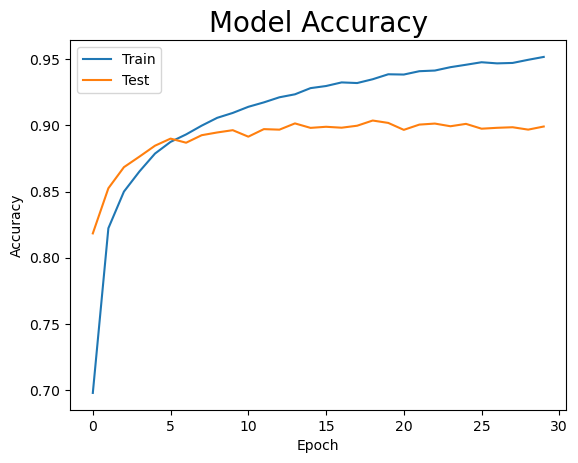

In [11]:
#输出准确率变化
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy',fontsize='20')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train','Test'],loc='upper left')
plt.show()

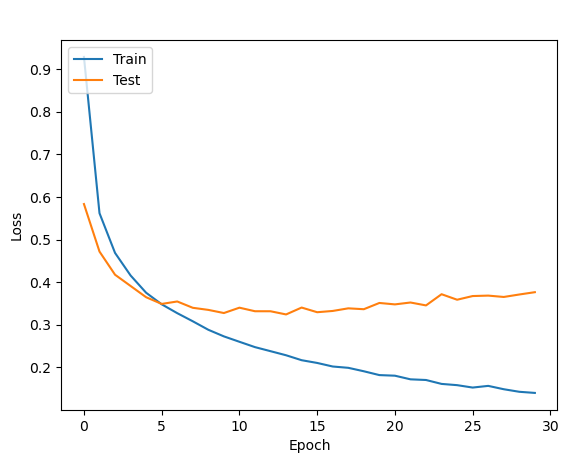

In [12]:
#损失值变化
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize='20',color='white')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [13]:
# model=load_model('quickdraw.model')
# model.summary()

img_width=28
img_heigth=28

## 模型预测--从测试集中抽取数据预测


这幅涂鸦是--> 蚂蚁 <--的可能性为 99.999985
这幅涂鸦是--> 蚂蚁 <--的可能性为 99.996605
这幅涂鸦是--> 床 <--的可能性为 99.99926
这幅涂鸦是--> 书 <--的可能性为 100.0
这幅涂鸦是--> 自行车 <--的可能性为 100.0


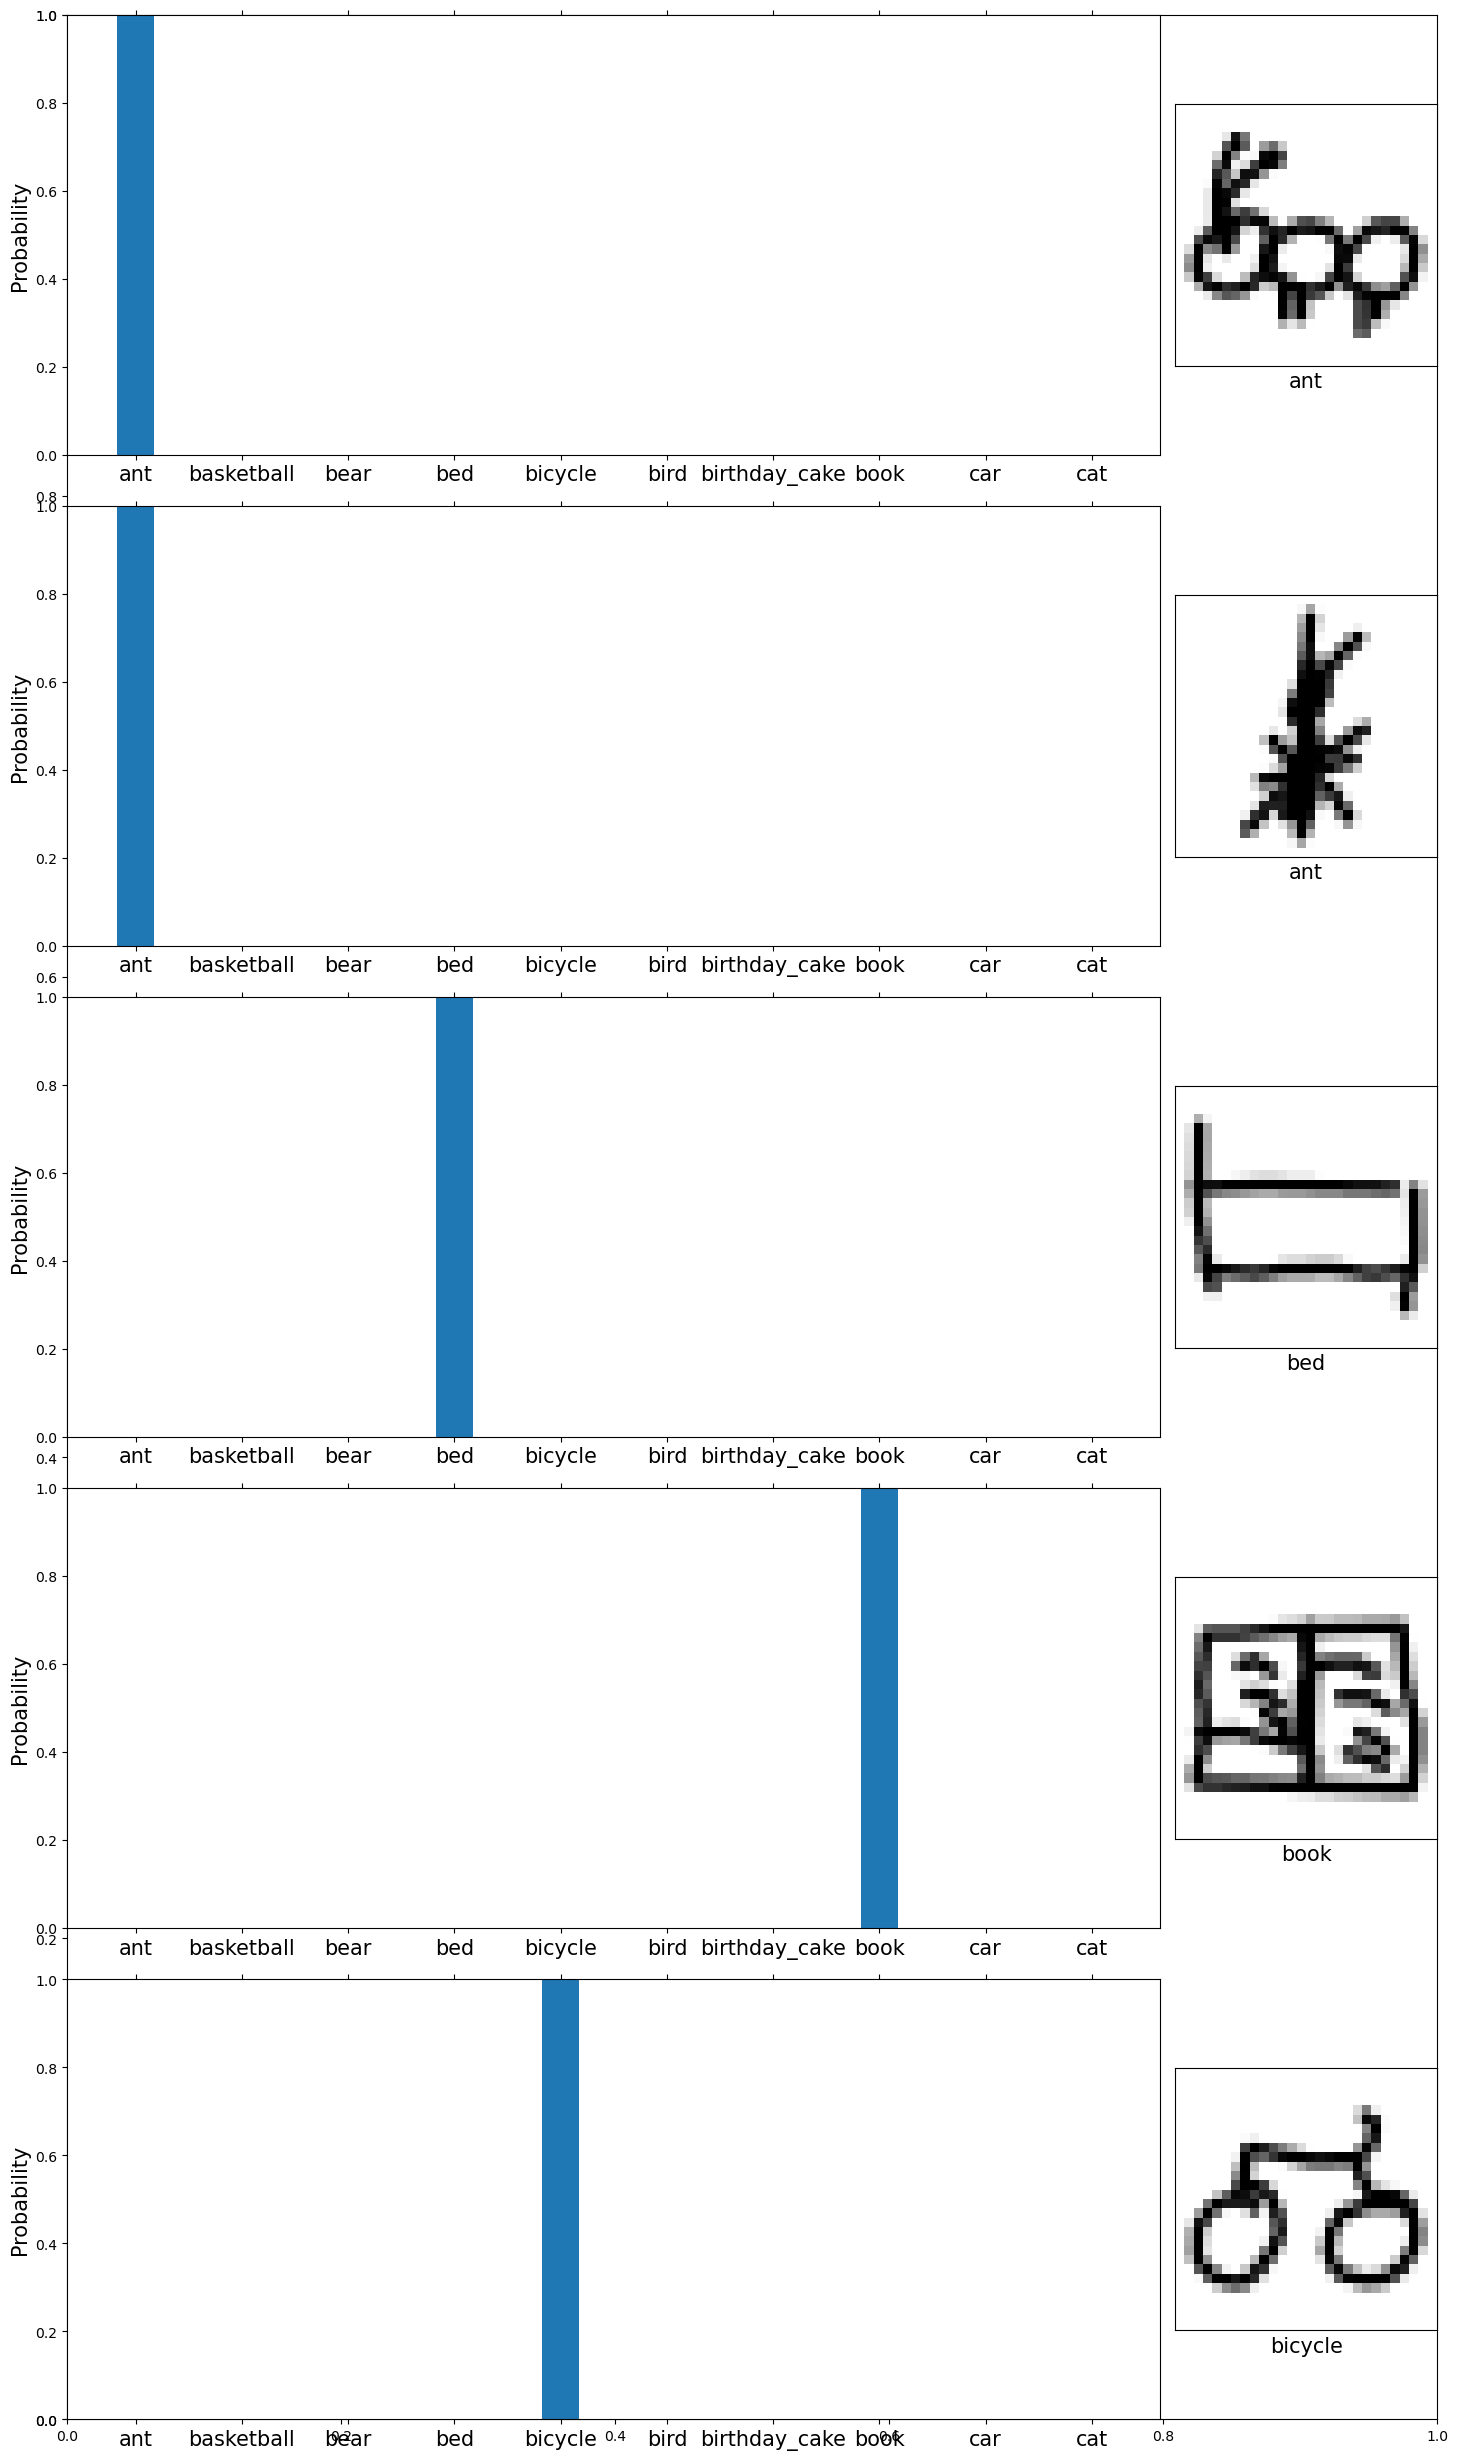

In [15]:
#将标签保存在字典中
label_dict={0:'蚂蚁',1:'篮球',2:'熊',3:'床',4:'自行车',5:'小鸟',6:'生日蛋糕',7:'书',8:'车',9:'猫'}
dataname=['ant','basketball','bear','bed','bicycle','bird','birthday_cake','book','car','cat']
label_dict_EN={0:'ant',1:'basketball',2:'bear',3:'bed',4:'bicycle',5:'bird',6:'birthday_cake',7:'book',8:'car',9:'cat'}
#预测值
cnn_probab=model.predict(X_test_cnn,batch_size=32,verbose=0)

fig,ax=plt.subplots(figsize=(15,25))
for i in list(range(5)):
    print('这幅涂鸦是-->',label_dict[y_test[i]],'<--的可能性为',max(cnn_probab[i]*100))
    
    #可能性表
    ax=plt.subplot2grid((5,5),(i,0),colspan=4)
    plt.bar(np.arange(10),cnn_probab[i],0.35,align='center')
    plt.xticks(np.arange(10),dataname,fontsize='15')
    plt.tick_params(axis='x',bottom='off',top='off')
    plt.ylabel('Probability',fontsize='15')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace=0.5)
    
    #数据集中的照片
    ax=plt.subplot2grid((5,5),(i,4),colspan=1)
    plt.imshow(X_test[i].reshape(28,28),cmap='gray_r',interpolation='nearest')
    plt.xlabel(label_dict_EN[y_test[i]],fontsize='15')
    plt.xticks([])
    plt.yticks([])
    fig.tight_layout() # 调整间距
plt.show()